In [2]:
import os
import cv2

In [3]:
dataset_dir = 'pet_facial_expression_dataset'

# List all image files in each category directory.
imgs_angry = os.listdir(os.path.join(dataset_dir, "Angry"))
imgs_happy = os.listdir(os.path.join(dataset_dir, "happy"))
imgs_other = os.listdir(os.path.join(dataset_dir, "Other"))
imgs_sad = os.listdir(os.path.join(dataset_dir, "Sad"))

# number of images in each category
print("Number of images in each category:")
print(f"Angry: {len(imgs_angry)}")
print(f"Happy: {len(imgs_happy)}")
print(f"Other: {len(imgs_other)}")
print(f"Sad: {len(imgs_sad)}")

Number of images in each category:
Angry: 250
Happy: 250
Other: 250
Sad: 250


In [4]:
#preprocess
def save_images(file_list, src_list, dst_dir):
    target_size = (224, 224)  
    for filename in file_list:
        src_path = os.path.join(src_list, filename)
        dst_path = os.path.join(dst_dir, filename)
        
        try:
            img = cv2.imread(src_path)
            if img is None:
                print(f"Warning: Could not read image {src_path}. Skipping.")
                continue

            img = cv2.resize(img, target_size)
            cv2.imwrite(dst_path, img)
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
            continue

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
from sklearn.model_selection import train_test_split

test_ratio = 0.1
val_ratio = 0.1

# Split each category into train and temporary sets
angry_train, angry_temp = train_test_split(imgs_angry, test_size=(test_ratio + val_ratio), random_state=42)
happy_train, happy_temp = train_test_split(imgs_happy, test_size=(test_ratio + val_ratio), random_state=42)
other_train, other_temp = train_test_split(imgs_other, test_size=(test_ratio + val_ratio), random_state=42)
sad_train, sad_temp = train_test_split(imgs_sad, test_size=(test_ratio + val_ratio), random_state=42)

# Split temporary sets into validation and test sets
angry_val, angry_test = train_test_split(angry_temp, test_size=0.5, random_state=42)
happy_val, happy_test = train_test_split(happy_temp, test_size=0.5, random_state=42)
other_val, other_test = train_test_split(other_temp, test_size=0.5, random_state=42)
sad_val, sad_test = train_test_split(sad_temp, test_size=0.5, random_state=42)

print("\n📂 Dataset Split:\n")
print("Train:")
print(f"Angry: {len(angry_train)}, Happy: {len(happy_train)}, Other: {len(other_train)}, Sad: {len(sad_train)}")
print("\nValidation:")
print(f"Angry: {len(angry_val)}, Happy: {len(happy_val)}, Other: {len(other_val)}, Sad: {len(sad_val)}")
print("\nTest:")
print(f"Angry: {len(angry_test)}, Happy: {len(happy_test)}, Other: {len(other_test)}, Sad: {len(sad_test)}")


📂 Dataset Split:

Train:
Angry: 200, Happy: 200, Other: 200, Sad: 200

Validation:
Angry: 25, Happy: 25, Other: 25, Sad: 25

Test:
Angry: 25, Happy: 25, Other: 25, Sad: 25


In [6]:
#create output directories
output_dir = "preprocess_dataset"
categories = ["Angry", "happy", "Other", "Sad"]

for split in ["train", "validation", "test"]:
    for category in categories:
        make_dir(os.path.join(output_dir, split, category))

In [7]:
# resize and save images to respective directories

print("\n🔄 Resizing and saving training images...")
save_images(angry_train, os.path.join(dataset_dir, "Angry"), os.path.join(output_dir, "train", "Angry"))
save_images(happy_train, os.path.join(dataset_dir, "happy"), os.path.join(output_dir, "train", "happy"))
save_images(other_train, os.path.join(dataset_dir, "Other"), os.path.join(output_dir, "train", "Other"))
save_images(sad_train, os.path.join(dataset_dir, "Sad"), os.path.join(output_dir, "train", "Sad"))

print("🔄 Resizing and saving validation images...")
save_images(angry_val, os.path.join(dataset_dir, "Angry"), os.path.join(output_dir, "validation", "Angry"))
save_images(happy_val, os.path.join(dataset_dir, "happy"), os.path.join(output_dir, "validation", "happy"))
save_images(other_val, os.path.join(dataset_dir, "Other"), os.path.join(output_dir, "validation", "Other"))
save_images(sad_val, os.path.join(dataset_dir, "Sad"), os.path.join(output_dir, "validation", "Sad"))

print("🔄 Resizing and saving test images...")
save_images(angry_test, os.path.join(dataset_dir, "Angry"), os.path.join(output_dir, "test", "Angry"))
save_images(happy_test, os.path.join(dataset_dir, "happy"), os.path.join(output_dir, "test", "happy"))
save_images(other_test, os.path.join(dataset_dir, "Other"), os.path.join(output_dir, "test", "Other"))
save_images(sad_test, os.path.join(dataset_dir, "Sad"), os.path.join(output_dir, "test", "Sad"))

print("✅ Preprocessing completed!")


🔄 Resizing and saving training images...
🔄 Resizing and saving validation images...
🔄 Resizing and saving test images...
✅ Preprocessing completed!


In [8]:
# create dataset with augmentation

import tensorflow as tf

batch_size = 32
img_size = (224, 224) 

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")

def create_datasets(batch_size, augment=True):
    print(f"\n📦 Creating datasets with batch size = {batch_size} ...")

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )

    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1), # these 0.1 here can increase to 0.15 for stronger aug.
            tf.keras.layers.RandomTranslation(0.1, 0.1), # can also use tf.keras.layers.RandomBrightness(0.1)
        ])
        train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    # apply vgg19 preprocessing
    normalization = tf.keras.applications.vgg19.preprocess_input
    train_ds = train_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # performance optimization
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    print(f"✅ Datasets for batch size {batch_size} loaded successfully!")
    return train_ds, val_ds

train_ds_32, val_ds_32 = create_datasets(32)

train_ds_64, val_ds_64 = create_datasets(64)



📦 Creating datasets with batch size = 32 ...
Found 800 files belonging to 4 classes.
Found 100 files belonging to 4 classes.

✅ Datasets for batch size 32 loaded successfully!

📦 Creating datasets with batch size = 64 ...
Found 800 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
✅ Datasets for batch size 64 loaded successfully!


In [9]:
# build a vgg19 transfer learning model
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

epoch =10
num_classes = 4

base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  
)

base_model.trainable = False  

model_vgg19 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-3), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg19.summary()
print("\n✅ VGG19 READY FOR TRAINING!")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20156740 (76.89 MB)
Trainable params: 132356 (517.02 KB)
Non-trainable params: 20024384 (76.39 MB)
______

In [10]:
epochs =10
print("\n🚀 Training with batch_size=32...")

history_vgg19_32 = model_vgg19.fit(
    train_ds_32,
    validation_data=val_ds_32,
    epochs=epochs
)
model_vgg19.save_weights("weights_batch32.h5")

print("🌱 Model weights for batch size of 32 saved!")


🚀 Training with batch_size=32...
Epoch 1/10


25/25 [==============================] - 30s 1s/step - loss: 5.6653 - accuracy: 0.3013 - val_loss: 2.6491 - val_accuracy: 0.5100
Epoch 2/10
25/25 [==============================] - 35s 1s/step - loss: 1.8815 - accuracy: 0.4950 - val_loss: 1.4502 - val_accuracy: 0.5500
Epoch 3/10
25/25 [==============================] - 36s 1s/step - loss: 1.1207 - accuracy: 0.5975 - val_loss: 0.9821 - val_accuracy: 0.6300
Epoch 4/10
25/25 [==============================] - 36s 1s/step - loss: 0.8033 - accuracy: 0.6750 - val_loss: 0.9188 - val_accuracy: 0.6700
Epoch 5/10
25/25 [==============================] - 36s 1s/step - loss: 0.7082 - accuracy: 0.7200 - val_loss: 0.8120 - val_accuracy: 0.7300
Epoch 6/10
25/25 [==============================] - 37s 1s/step - loss: 0.5811 - accuracy: 0.7725 - val_loss: 0.7028 - val_accuracy: 0.7700
Epoch 7/10
25/25 [==============================] - 39s 2s/step - loss: 0.4701 - accuracy: 0.8375 - val_loss: 0.7324 - val_a

In [11]:

print("\n🚀 Training with batch_size=64...")

'''
# model_vgg19.load_weights("weights_batch32.h5")  

reload the model again in case want to continue the training, but our goal here is to compare
between the two batch sizes, so we keep them separate.
'''

history_vgg19_64 = model_vgg19.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=epochs
)
model_vgg19.save_weights("weights_batch64.h5")

print("🌱 Model weights for batch size of 64 saved!")


🚀 Training with batch_size=64...
Epoch 1/10
13/13 [==============================] - 33s 3s/step - loss: 0.5526 - accuracy: 0.7850 - val_loss: 0.5608 - val_accuracy: 0.8300
Epoch 2/10
13/13 [==============================] - 35s 3s/step - loss: 0.4460 - accuracy: 0.8288 - val_loss: 0.5248 - val_accuracy: 0.8500
Epoch 3/10
13/13 [==============================] - 35s 3s/step - loss: 0.4283 - accuracy: 0.8438 - val_loss: 0.4962 - val_accuracy: 0.8500
Epoch 4/10
13/13 [==============================] - 35s 3s/step - loss: 0.3991 - accuracy: 0.8562 - val_loss: 0.4861 - val_accuracy: 0.8700
Epoch 5/10
13/13 [==============================] - 35s 3s/step - loss: 0.3345 - accuracy: 0.8825 - val_loss: 0.4308 - val_accuracy: 0.8700
Epoch 6/10
13/13 [==============================] - 35s 3s/step - loss: 0.3319 - accuracy: 0.8863 - val_loss: 0.4356 - val_accuracy: 0.8800
Epoch 7/10
13/13 [==============================] - 35s 3s/step - loss: 0.2832 - accuracy: 0.9075 - val_loss: 0.4822 - val_acc

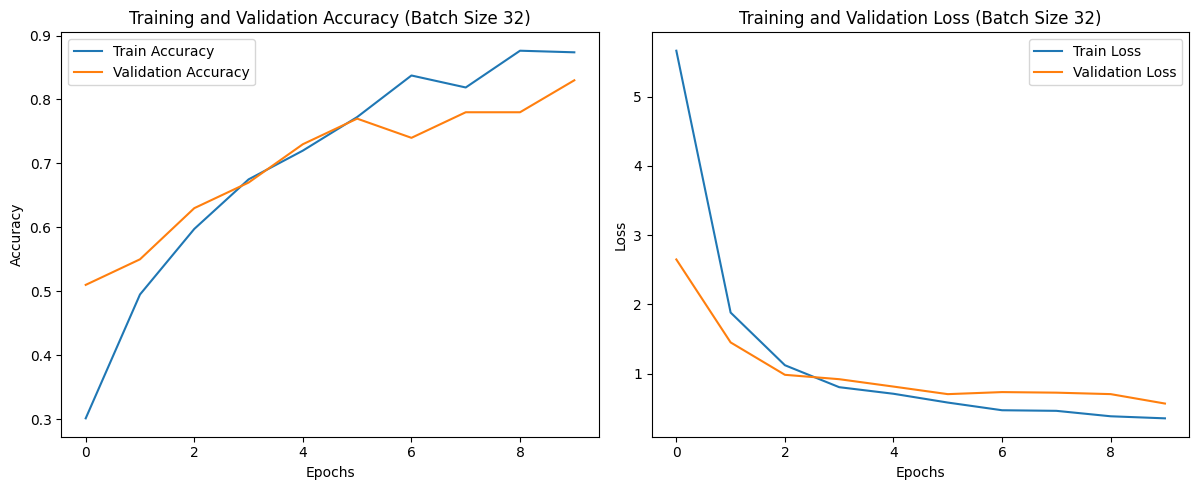

📊 Evaluation plots generated for batch size 32.


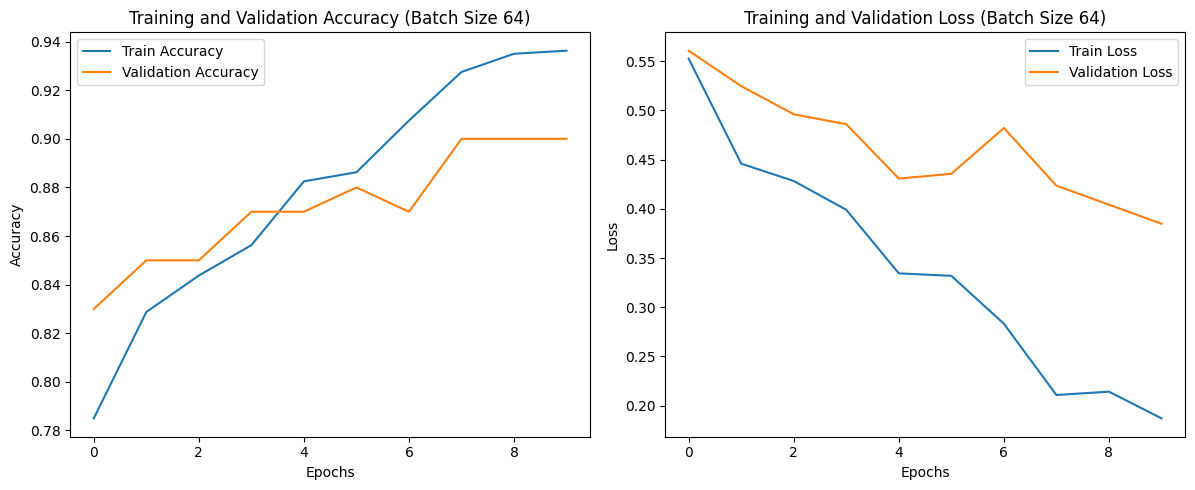

📊 Evaluation plots generated for batch size 64.


In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history, batch_size):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Optional: AUC (only exists if added during compile)
    auc = history.history.get('auc')
    val_auc = history.history.get('val_auc')
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(18, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Batch Size {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss (Batch Size {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # AUC plot 
    if auc and val_auc:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, auc, label='Train AUC')
        plt.plot(epochs_range, val_auc, label='Validation AUC')
        plt.title(f'Training and Validation AUC (Batch Size {batch_size})')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

    plt.tight_layout()
    plt.show()
    print(f"📊 Evaluation plots generated for batch size {batch_size}.")

plot_training_history(history_vgg19_32, 32)

plot_training_history(history_vgg19_64, 64)

> For batch size 32:
 - Accuracy plot: staring from approx 30% to ~51% after epoch 1 shows that the model quickly captures basic patterns. It then steadily continues climbing with a smooth upward trend. The gap between final train&val is (~6%) is small and consistent, indicating healthy learning and minimal overfitting.
 - Loss plot: a dramatic initial drop makes it to plummet from ~5.8 to ~2.5 in 1st epoch, then continues to decline gradually. Both training and val losses follow similar downward trends, showing stable convergemce without signs od divergence or instability.

> For batch size 64:
- Accuracy plot: it has a better start with ~78% rate after epoch 1 (much higherthat batch 32), and reaches high accuracy point quicker. The gap between final train&val is ~4%, which is still acceptable (strong consistency and better fit).
- Loss plot: training loss decreases steadily, while validation loss fluctuates slightly but ultimately follows a downward trend, suggesting smooth optimization and improved generalization.

We can conclude that batch64 outperforms batch32 in terms of convergence speed, final train- and val- accuracy, and training stability (smoother loss curve and smaller gap). However, batch size 32 still shows slightly better resistance to overfitting, as its validation curve is smoother and more consistent across epochs.

In [13]:
# tl_facial_test.ipynb
# 🧪 Model Testing (Batch Size 32)
model_vgg19.load_weights("weights_batch32.h5")

# Create test dataset
test_dir = os.path.join(output_dir, "test")
test_ds_32 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,          
    image_size=img_size,    
    shuffle=False
)

normalization = tf.keras.applications.vgg19.preprocess_input
test_ds_32 = test_ds_32.map(lambda x, y: (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_32 = test_ds_32.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# evaluate the model 
test_loss_32, test_acc_32 = model_vgg19.evaluate(test_ds_32)
print(f"\n📊 Batch Size 32 Test Results:")
print(f"Test Loss: {test_loss_32:.4f}")
print(f"Test Accuracy: {test_acc_32:.4f}")

# Make predictions on the test dataset
predictions_32 = model_vgg19.predict(test_ds_32)  
predicted_labels_32 = predictions_32.argmax(axis=1)

# Extract true labels from test dataset
true_labels_32 = []
for images, labels in test_ds_32:
    true_labels_32.extend(labels.numpy())

# Print first 10 predictions vs true labels
emotion_labels = ['Angry', 'happy', 'Other', 'Sad']
print("\n🧩 Sample Predictions (Batch Size 32):")
for i in range(10):
    print(f"Predicted: {emotion_labels[predicted_labels_32[i]]}, True: {emotion_labels[true_labels_32[i]]}")

Found 100 files belonging to 4 classes.
4/4 [==============================] - 3s 582ms/step - loss: 0.6814 - accuracy: 0.8200

📊 Batch Size 32 Test Results:
Test Loss: 0.6814
Test Accuracy: 0.8200
4/4 [==============================] - 3s 586ms/step

🧩 Sample Predictions (Batch Size 32):
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: happy, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry


In [14]:
# 🧪 Model Testing (Batch Size 64)

model_vgg19.load_weights("weights_batch64.h5")

# Create test dataset
test_ds_64 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=64,          
    image_size=img_size,    
    shuffle=False
)
test_ds_64 = test_ds_64.map(lambda x, y: (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_64 = test_ds_64.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# evaluate the model 
test_loss_64, test_acc_64 = model_vgg19.evaluate(test_ds_64)
print(f"\n📊 Batch Size 64 Test Results:")
print(f"Test Loss: {test_loss_64:.4f}")
print(f"Test Accuracy: {test_acc_64:.4f}")

# Make predictions on the test dataset
predictions_64 = model_vgg19.predict(test_ds_64)  
predicted_labels_64 = predictions_64.argmax(axis=1)

# Extract true labels from test dataset
true_labels_64 = []
for images, labels in test_ds_64:
    true_labels_64.extend(labels.numpy())

# Print first 10 predictions vs true labels
emotion_labels = ['Angry', 'happy', 'Other', 'Sad']
print("\n🧩 Sample Predictions (Batch Size 64):")
for i in range(10):
    print(f"Predicted: {emotion_labels[predicted_labels_64[i]]}, True: {emotion_labels[true_labels_64[i]]}")

Found 100 files belonging to 4 classes.
2/2 [==============================] - 3s 913ms/step - loss: 0.5604 - accuracy: 0.8700

📊 Batch Size 64 Test Results:
Test Loss: 0.5604
Test Accuracy: 0.8700
2/2 [==============================] - 3s 1s/step

🧩 Sample Predictions (Batch Size 64):
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: Angry, True: Angry
Predicted: happy, True: Angry
Predicted: Angry, True: Angry
Predicted: Sad, True: Angry


<Figure size 700x700 with 0 Axes>

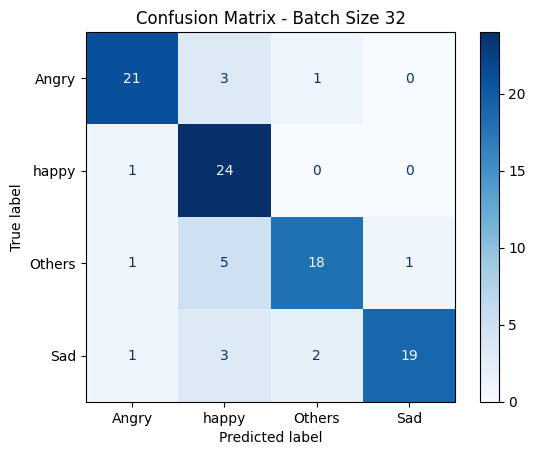

In [15]:
# Evaluate Model Performance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# get true labels from test dataset
true_labels_32 = []
for images, labels in test_ds_32:
    true_labels_32.extend(labels.numpy())

# compute and plot confusion matrix
class_names = ['Angry', 'happy', 'Others', 'Sad']
cm_32 = confusion_matrix(true_labels_32, predicted_labels_32)
disp_32 = ConfusionMatrixDisplay(confusion_matrix=cm_32, display_labels=class_names)

plt.figure(figsize=(7,7))
disp_32.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Batch Size 32")
plt.show()


<Figure size 700x700 with 0 Axes>

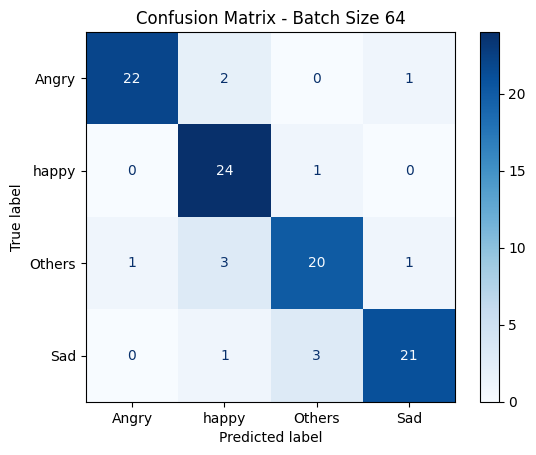

In [16]:
# true label
true_labels_64 = []
for images, labels in test_ds_64:
    true_labels_64.extend(labels.numpy())

# compute and plot confusion matrix
class_names = ['Angry', 'happy', 'Others', 'Sad']
cm_64 = confusion_matrix(true_labels_64, predicted_labels_64)
disp_64 = ConfusionMatrixDisplay(confusion_matrix=cm_64, display_labels=class_names)

plt.figure(figsize=(7,7))
disp_64.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Batch Size 64")
plt.show()

"Happy" is perfectly identified (24/25) in both models, suggesting this is the easiest emotion to detect, likely due to distinctive features like open mouths or relaxed facial expressions. However, the "Others" category remains the most challenging for both models, which somehow makes sense since it's a catch-all category that might contain diverse expressions that don't fit the other three emotions.

> From both matrices, we can clearly see that batch size 64 gives a more mature, well-trained model with better discrimination between classes. 


2/2 [==============================] - 1s 126ms/step


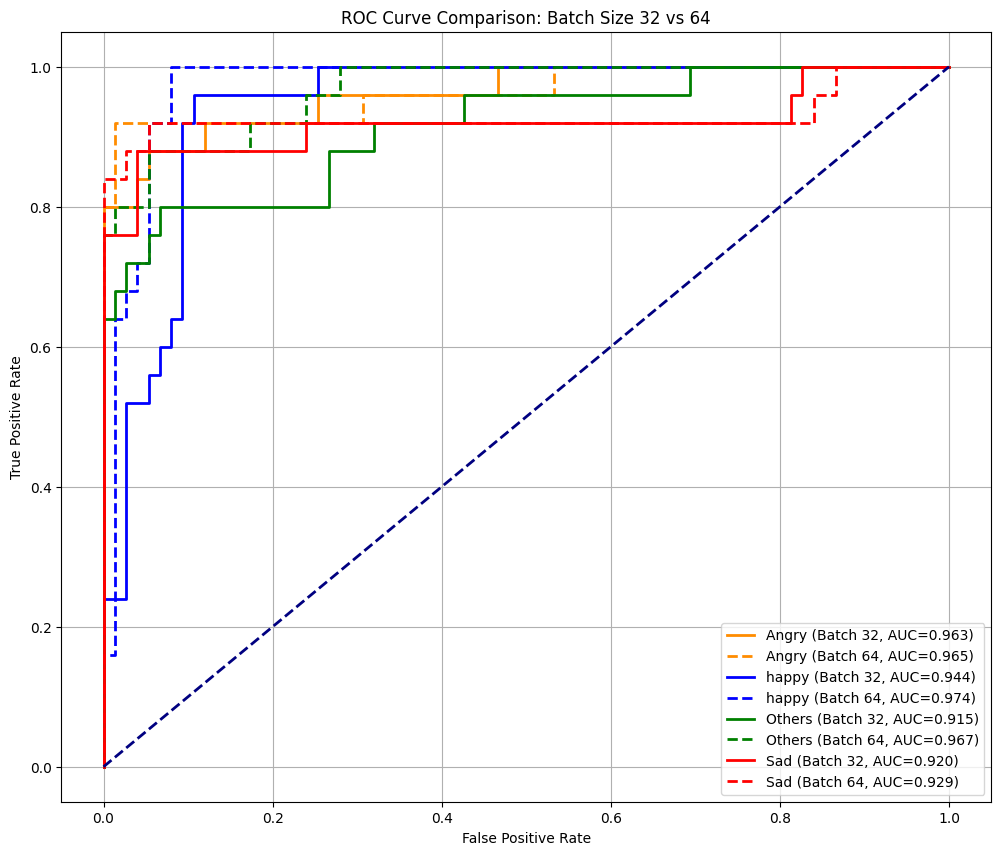

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Angry', 'happy', 'Others', 'Sad']
n_classes = len(class_names)

def get_true_and_probs(model, test_ds):
    true_labels = []
    pred_probs = []
    for images, labels in test_ds:
        preds = model.predict(images)
        pred_probs.extend(preds)
        true_labels.extend(labels.numpy())
    return np.array(true_labels), np.array(pred_probs)

# batch 32
model_vgg19.load_weights("weights_batch32.h5")
true_32, probs_32 = get_true_and_probs(model_vgg19, test_ds_32)
true_32_bin = label_binarize(true_32, classes=np.arange(n_classes))

# batch 64
model_vgg19.load_weights("weights_batch64.h5")
true_64, probs_64 = get_true_and_probs(model_vgg19, test_ds_64)
true_64_bin = label_binarize(true_64, classes=np.arange(n_classes))

plt.figure(figsize=(12, 10))
colors = ['darkorange', 'blue', 'green', 'red']

for i in range(n_classes):
    # Batch 32
    fpr32, tpr32, _ = roc_curve(true_32_bin[:, i], probs_32[:, i])
    roc_auc32 = auc(fpr32, tpr32)
    plt.plot(fpr32, tpr32, linestyle='-', color=colors[i],
             lw=2, label=f'{class_names[i]} (Batch 32, AUC={roc_auc32:.3f})')
    
    # Batch 64
    fpr64, tpr64, _ = roc_curve(true_64_bin[:, i], probs_64[:, i])
    roc_auc64 = auc(fpr64, tpr64)
    plt.plot(fpr64, tpr64, linestyle='--', color=colors[i],
             lw=2, label=f'{class_names[i]} (Batch 64, AUC={roc_auc64:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve Comparison: Batch Size 32 vs 64')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

> Based on the ROC Curve, all AUCs for batch 64 > batch 32; this means batch 64 had a stronger ability to distinguish between classes. additionally, the curves are closer to the top-left corner for batch 64, confirming higher true-positive rates for similar false-positive levels. still, the differences in AUC are modest (mostly within 0.02–0.05); both models maintain good discriminative performance overall.

We can say that batch 64 demonstrates enhanced class separation and more powerful discrimination, but with a slightly higher risk of overfitting. Meanwhile, batch 32 offers more balanced and stable generalization, which may be preferable for smaller or more diverse datasets.

> In conclusion, both configurations demonstrate strong performance in emotion classification, but batch size 64 produced slightly better classification power at the cost of potential overfitting. batch size 32, on the other hand, offered more stable and balanced learning behavior, making it more suitable when dealing with noisier or smaller datasets.

In [ ]:
# ============================================================================
# BONUS: Fine-tuning the last layers of VGG19
# ============================================================================
# batch 64 gives higher accuracy on training, val, and test sets, so we proceed with that one

#load model
model_vgg19.load_weights("weights_batch64.h5")

print("\n🔓 Fine-tuning last layers of VGG19...")

# Unfreeze the last 4 layers of VGG19
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# recompile with lower learning rate for fine-tuning
model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-5),  # much lower for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model ready for fine-tuning. Run .fit() again to continue training!")


🔓 Fine-tuning last layers of VGG19...
Model ready for fine-tuning. Run .fit() again to continue training!


In [19]:
print("\n🚀 Training with batch_size=64...")

history_vgg19_64 = model_vgg19.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=10
)
model_vgg19.save_weights("weights_batch64_final-tuned.h5")

print("🌱 Model weights for batch size of 64 saved!")


🚀 Training with batch_size=64...
Epoch 1/10
13/13 [==============================] - 36s 3s/step - loss: 0.1906 - accuracy: 0.9400 - val_loss: 0.4302 - val_accuracy: 0.9000
Epoch 2/10
13/13 [==============================] - 40s 3s/step - loss: 0.1651 - accuracy: 0.9438 - val_loss: 0.3839 - val_accuracy: 0.9100
Epoch 3/10
13/13 [==============================] - 39s 3s/step - loss: 0.1473 - accuracy: 0.9600 - val_loss: 0.3912 - val_accuracy: 0.9100
Epoch 4/10
13/13 [==============================] - 39s 3s/step - loss: 0.1338 - accuracy: 0.9563 - val_loss: 0.3364 - val_accuracy: 0.9100
Epoch 5/10
13/13 [==============================] - 39s 3s/step - loss: 0.1055 - accuracy: 0.9762 - val_loss: 0.3607 - val_accuracy: 0.9200
Epoch 6/10
13/13 [==============================] - 39s 3s/step - loss: 0.0880 - accuracy: 0.9800 - val_loss: 0.3636 - val_accuracy: 0.9100
Epoch 7/10
13/13 [==============================] - 39s 3s/step - loss: 0.0829 - accuracy: 0.9800 - val_loss: 0.3477 - val_acc

In [ ]:
# evaluate tuned model (weights_batch64_final-tuned.h5)
from sklearn.metrics import accuracy_score

model_vgg19.load_weights("weights_batch64_final-tuned.h5")

test_dir = os.path.join(output_dir, "test")
test_ds_tuned = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=img_size,
    shuffle=False
)

normalization = tf.keras.applications.vgg19.preprocess_input
test_ds_tuned = test_ds_tuned.map(lambda x, y: (normalization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_tuned = test_ds_tuned.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_loss, test_acc = model_vgg19.evaluate(test_ds_tuned)
print(f"\n📊 Tuned model test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Found 100 files belonging to 4 classes.
2/2 [==============================] - 3s 921ms/step - loss: 0.5943 - accuracy: 0.8900

📊 Tuned model test Loss: 0.5943, Test Accuracy: 0.8900
